<a href="https://colab.research.google.com/github/Apitoxinum/SF-cardiovascular-disease/blob/main/SF_DL_NN_Project_CVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch
import torch.nn as nn

In [32]:
train_df = pd.read_csv("/train.csv")
test_df = pd.read_csv("/test.csv")

In [33]:
# Просмотр первых 5 строк обучающих данных
print("Первые 5 строк обучающих данных:")
display(train_df.head())

# Основная информация о данных (типы столбцов, количество ненулевых значений)
print("\nИнформация о обучающих данных:")
train_df.info()

# Проверка на пропущенные значения
print("\nПропущенные значения в обучающих данных:")
print(train_df.isnull().sum())

Первые 5 строк обучающих данных:


,ID,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,0,49.207124,0,4.000000,162.996167,181.108682,0,0,148.227858,1,0.944547,2,0,3,1
1,1,53.628425,1,1.741596,130.233730,276.474630,0,2,152.917139,0,0.119070,2,0,3,0
2,2,49.591426,1,4.000000,146.999012,223.300517,1,2,102.352090,1,1.616747,2,2,7,1
3,3,58.991445,1,4.000000,112.369143,187.245501,0,0,158.164750,1,0.000000,1,1,7,1
4,4,51.053602,1,1.954609,138.032047,238.482868,0,0,172.540828,0,1.150464,1,1,3,0



Информация о обучающих данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    600000 non-null  int64  
 1   age                                   600000 non-null  float64
 2   sex                                   600000 non-null  int64  
 3   chest                                 600000 non-null  float64
 4   resting_blood_pressure                600000 non-null  float64
 5   serum_cholestoral                     600000 non-null  float64
 6   fasting_blood_sugar                   600000 non-null  int64  
 7   resting_electrocardiographic_results  600000 non-null  int64  
 8   maximum_heart_rate_achieved           600000 non-null  float64
 9   exercise_induced_angina               600000 non-null  int64  
 10  oldpeak                             

In [34]:
# Удалим ID - он не нужен для модели
train_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

Первые наблюдения:

* Данные уже в числовом формате, что удобно для работы.

* Пропущенных значений нет.

* Некоторые значения представлены как float (дробные числа), хотя должны быть целыми (например, возраст, количество сосудов).

* Нужно проверить диапазоны значений на соответствие описанию.

In [35]:
# Проверка уникальных значений в категориальных признаках
categorical_features = ['sex', 'fasting_blood_sugar',
                        'resting_electrocardiographic_results',
                        'exercise_induced_angina', 'slope',
                        'number_of_major_vessels', 'thal', 'class']

for feature in categorical_features:
    print(f"{feature}: {sorted(train_df[feature].unique())}")

sex: [np.int64(0), np.int64(1)]
fasting_blood_sugar: [np.int64(0), np.int64(1)]
resting_electrocardiographic_results: [np.int64(0), np.int64(1), np.int64(2)]
exercise_induced_angina: [np.int64(0), np.int64(1)]
slope: [np.int64(1), np.int64(2), np.int64(3)]
number_of_major_vessels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
thal: [np.int64(3), np.int64(6), np.int64(7)]
class: [np.int64(0), np.int64(1)]


In [36]:
# Преобразуем целочисленные признаки
int_features = ['age', 'number_of_major_vessels', 'thal']
for feature in int_features:
    train_df[feature] = train_df[feature].astype(int)
    test_df[feature] = test_df[feature].astype(int)

# Проверим результат
print("\nТипы данных после преобразования:")
train_df[int_features].dtypes


Типы данных после преобразования:


,0
age,int64
number_of_major_vessels,int64
thal,int64


Распределение классов:
class
0    333489
1    266511
Name: count, dtype: int64


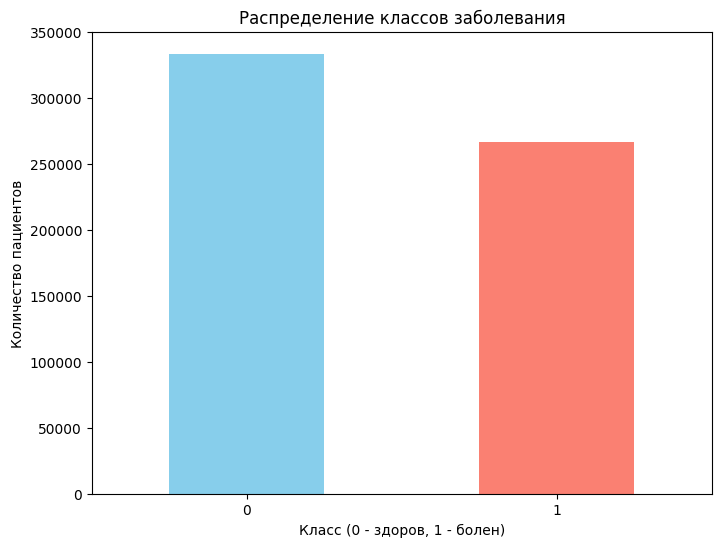

In [37]:
# Распределение классов
import matplotlib.pyplot as plt

class_distribution = train_df['class'].value_counts()
print("Распределение классов:")
print(class_distribution)

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение классов заболевания')
plt.xlabel('Класс (0 - здоров, 1 - болен)')
plt.ylabel('Количество пациентов')
plt.xticks(rotation=0)
plt.show()

In [38]:
# Основные статистики по числовым признакам
numeric_features = ['age', 'resting_blood_pressure', 'serum_cholestoral',
                    'maximum_heart_rate_achieved', 'oldpeak']

print("Основные статистики:")
train_df[numeric_features].describe()

Основные статистики:


,age,resting_blood_pressure,serum_cholestoral,maximum_heart_rate_achieved,oldpeak
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,53.926715,131.340485,249.592420,149.592069,1.051391
std,9.091247,17.842450,51.699976,23.072593,1.144288
min,26.000000,82.918527,98.326263,61.844168,-0.806788
25%,48.000000,119.924094,216.475964,135.704237,0.000000
50%,55.000000,129.727941,244.233699,153.224828,0.811101
75%,60.000000,139.915216,274.345453,165.165497,1.674081
max,79.000000,209.673650,527.755764,208.735196,6.803372


In [39]:
# Проверим уникальные значения chest до преобразования
print("Уникальные значения chest до преобразования:", train_df['chest'].unique())

Уникальные значения chest до преобразования: [4.       1.741596 1.954609 ... 1.680331 1.949117 1.295676]


In [40]:
# Преобразуем 'chest' в категориальный
train_df['chest'] = train_df['chest'].clip(1, 4).round().astype(int)
test_df['chest'] = test_df['chest'].clip(1, 4).round().astype(int)
print("Уникальные значения chest после преобразования:", train_df['chest'].unique())


Уникальные значения chest после преобразования: [4 2 3 1]


In [41]:
# one-hot encoding
categorical_features = ['chest', 'resting_electrocardiographic_results', 'slope', 'thal']
train_df = pd.get_dummies(train_df, columns=categorical_features, prefix=categorical_features)
test_df = pd.get_dummies(test_df, columns=categorical_features, prefix=categorical_features)

# Проверяем результат
print("\nКолонки после преобразования:")
print(train_df.columns.tolist())


Колонки после преобразования:
['age', 'sex', 'resting_blood_pressure', 'serum_cholestoral', 'fasting_blood_sugar', 'maximum_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak', 'number_of_major_vessels', 'class', 'chest_1', 'chest_2', 'chest_3', 'chest_4', 'resting_electrocardiographic_results_0', 'resting_electrocardiographic_results_1', 'resting_electrocardiographic_results_2', 'slope_1', 'slope_2', 'slope_3', 'thal_3', 'thal_6', 'thal_7']


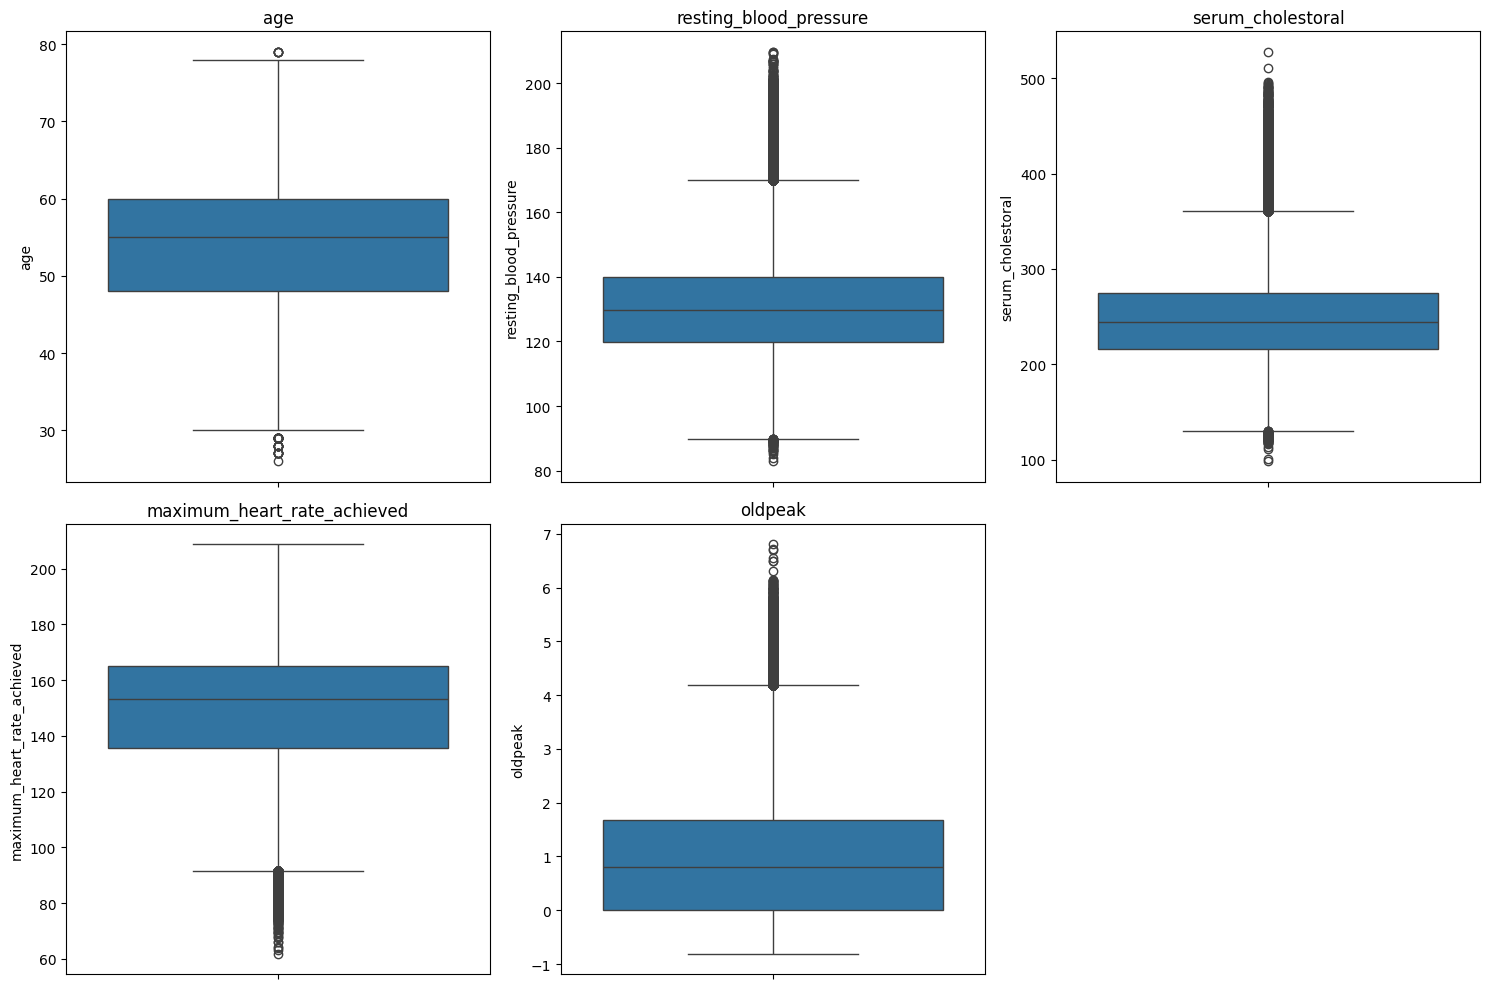

In [42]:
# Визуализация выбросов для числовых признаков
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=train_df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()


In [43]:
# Обработка выбросов:
def handle_outliers(df):
    df = df.copy()
    # Артериальное давление
    df['resting_blood_pressure'] = df['resting_blood_pressure'].clip(80, 200)
    # Холестерин
    df['serum_cholestoral'] = df['serum_cholestoral'].clip(100, 400)
    # Пульс
    df['maximum_heart_rate_achieved'] = df['maximum_heart_rate_achieved'].clip(60, 220)
    # Депрессия ST
    df['oldpeak'] = df['oldpeak'].clip(0, 6)
    return df

train_df = handle_outliers(train_df)
test_df = handle_outliers(test_df)

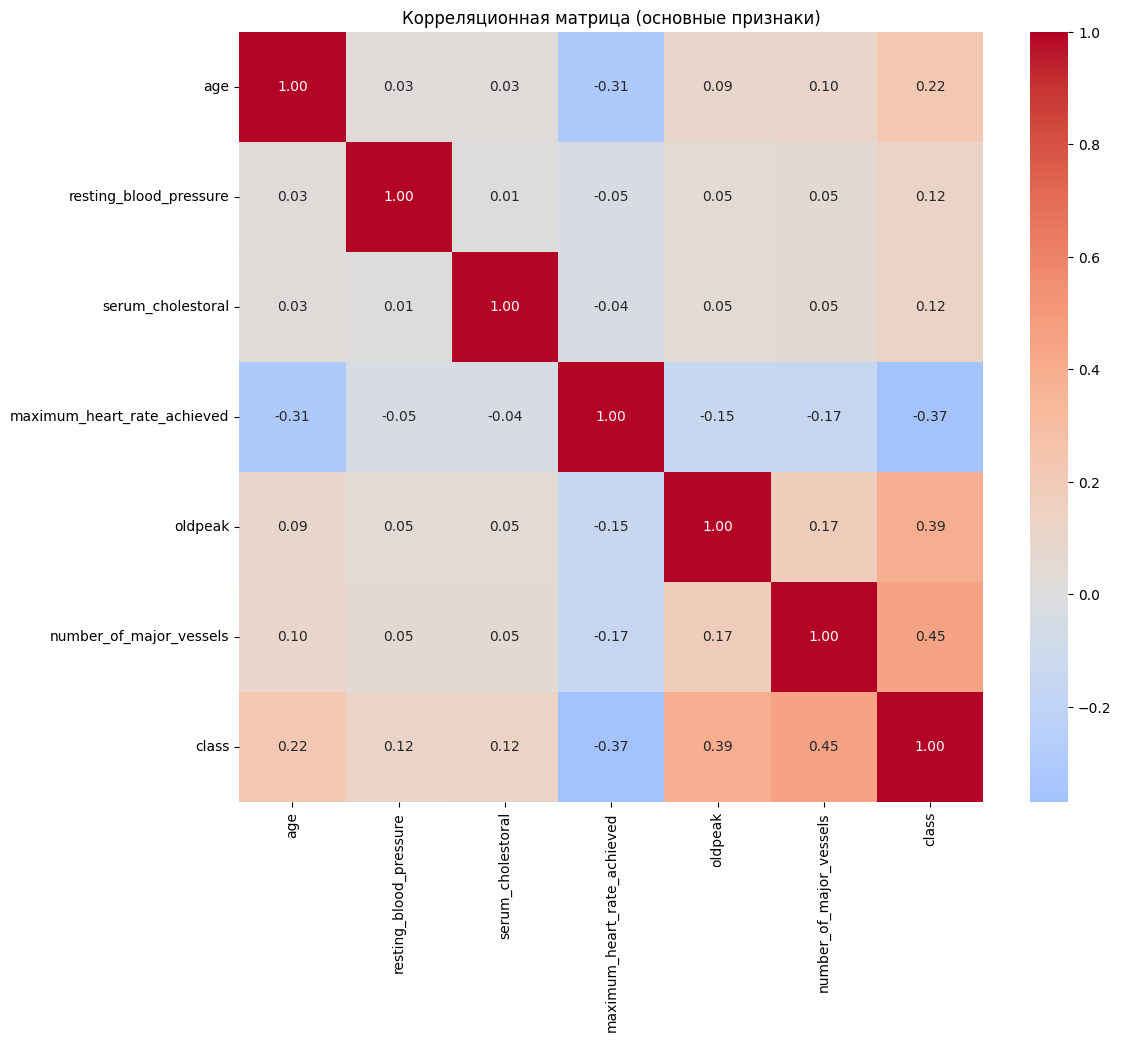

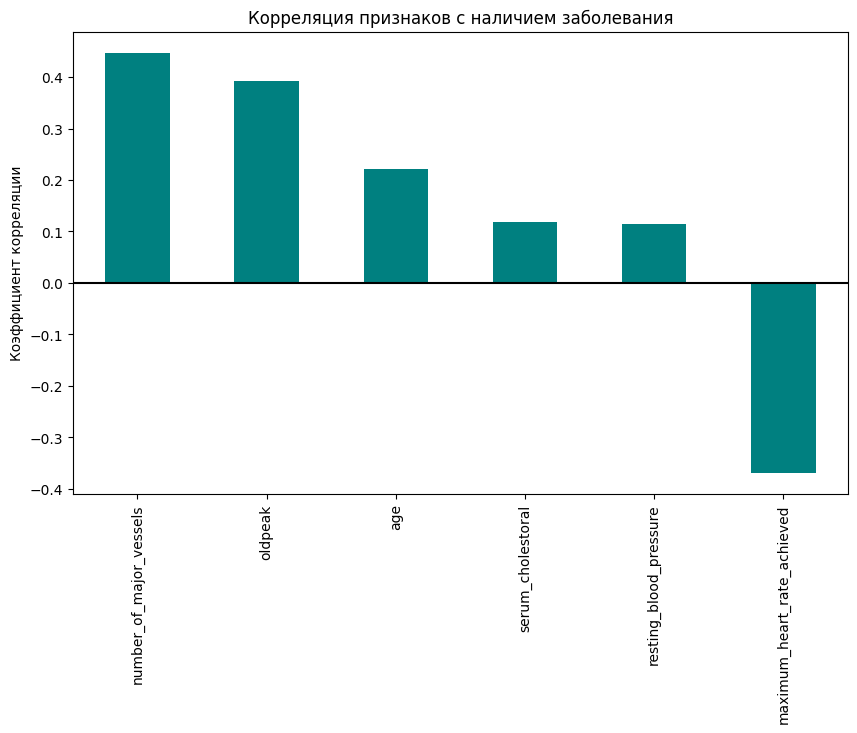

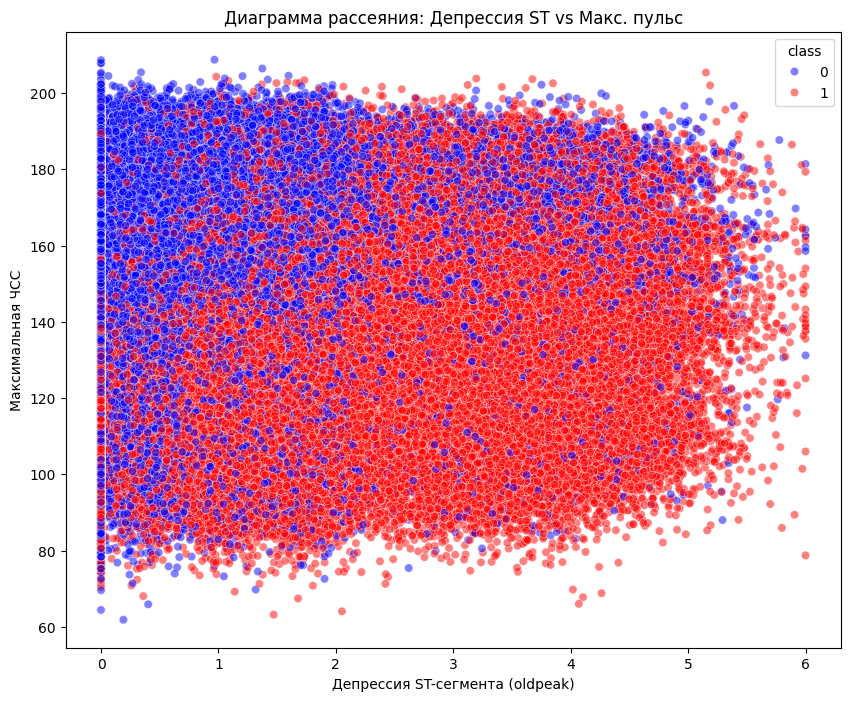

In [44]:
# Тепловая карта корреляций
# Выберем основные признаки и целевую переменную
selected_features = [
    'age',
    'resting_blood_pressure',
    'serum_cholestoral',
    'maximum_heart_rate_achieved',
    'oldpeak',
    'number_of_major_vessels',
    'class'
]

# Тепловая карта
plt.figure(figsize=(12, 10))
corr_matrix = train_df[selected_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Корреляционная матрица (основные признаки)')
plt.show()

# Корреляция с целевой переменной
plt.figure(figsize=(10, 6))
corr_with_target = corr_matrix['class'].sort_values(ascending=False)
corr_with_target.drop('class', inplace=True)
corr_with_target.plot(kind='bar', color='teal')
plt.title('Корреляция признаков с наличием заболевания')
plt.ylabel('Коэффициент корреляции')
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

# Диаграмма рассеяния для наиболее коррелированных признаков
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='oldpeak',
    y='maximum_heart_rate_achieved',
    hue='class',
    data=train_df,
    alpha=0.5,
    palette={0: 'blue', 1: 'red'}
)
plt.title('Диаграмма рассеяния: Депрессия ST vs Макс. пульс')
plt.xlabel('Депрессия ST-сегмента (oldpeak)')
plt.ylabel('Максимальная ЧСС')
plt.show()